# Simulate second-order systems

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, solvers
from odefilter.implementations import implementations
from odefilter.strategies import filters

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

Quick refresher: first-order ODEs

In [2]:
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf_1(y, t, p):
    return f(y, *p)


ts0_1 = solvers.MLESolver.from_params()
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [3]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf_1,
    initial_values=(u0,),
    ts=ts,
    solver=ts0_1,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 5.61 s, sys: 64.8 ms, total: 5.67 s
Wall time: 5.37 s


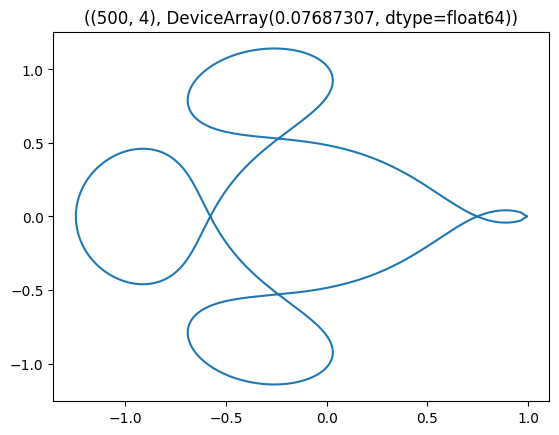

In [4]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1])
plt.show()

The default configuration assumes that the ODE to be solved is of first order.
In fact, above, we used the following solver:


In [5]:
implementation = implementations.IsoTS0.from_params(ode_order=1, num_derivatives=4)
ts0_1_granular = solvers.MLESolver(
    strategy=filters.Filter(implementation=implementation)
)
assert ts0_1_granular == ts0_1

Now, the same game with a second-order ODE

In [6]:
f, (u0, du0), (t0, t1), f_args = ivps.three_body_restricted()


@jax.jit
def vf_2(y, dy, t, p):
    return f(y, dy, *p)


# One derivative more than above because we don't transform to first order
implementation = implementations.IsoTS0.from_params(ode_order=2, num_derivatives=5)
ts0_2 = solvers.MLESolver(strategy=filters.Filter(implementation=implementation))
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [7]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf_2,
    initial_values=(u0, du0),
    ts=ts,
    solver=ts0_2,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 5.48 s, sys: 60.9 ms, total: 5.54 s
Wall time: 5.25 s


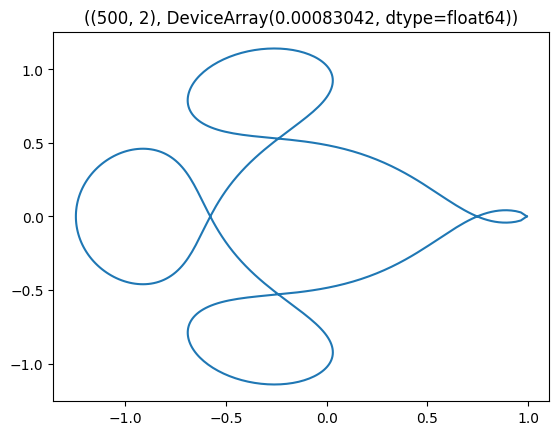

In [8]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1])
plt.show()

The second-order solver is faster and way more accurate.